# Import Statements

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

In [2]:
# Mapping packages:
import folium

In [3]:
# import geopandas as gpd

To install geopandas and folium:

`conda install -c conda-forge geopandas`

`conda install -c conda-forge folium `

then:

`jupyter nbextension enable vega --py --sys-prefix`

to enable the necessary notebook extension to use Folium.

# Importing Data

In [4]:
# Don't edit raw dataframes after they have been imported:
train_raw = pd.read_csv('assets/train.csv')
test_raw = pd.read_csv('assets/test.csv', index_col=0)
weather_raw = pd.read_csv('assets/weather.csv')
spray_raw = pd.read_csv('assets/spray.csv')

# These can be the cleaned versions:
train = train_raw.copy().drop(['Address','Block','Street','AddressNumberAndStreet','AddressAccuracy'], axis=1)
test = test_raw.copy().drop(['Address','Block','Street','AddressNumberAndStreet', 'AddressAccuracy'], axis=1)
# If we're using latitude and longitude we can drop out the address info.
weather = weather_raw.copy()
spray = spray_raw.copy()

# Cleaning Data and EDA, train and test

## Simple Map showing the Weather Stations (airports)

In [ ]:
m = folium.Map(
    location=[41.883844, -87.632162],
    tiles='openstreetmap',
    zoom_start=10,
    max_zoom = 10,
    min_zoom = 10
)

#folium.tooltip = 'Click Me!' #WARNING: Tooltips are not in this release; use the dev one if you want it

folium.Marker([41.973312, -87.910576], popup='OHare Iternational Airport', icon=folium.Icon(icon='plane', color = 'red')).add_to(m)
folium.Marker([41.786, -87.752], popup='Midway International Airport', icon=folium.Icon(icon='plane', color = 'green')).add_to(m)

m

## Examining the training set:

In [5]:
test['Date'] = pd.to_datetime(test['Date'], format='%Y/%m/%d')
train['Date'] = pd.to_datetime(train['Date'], format='%Y/%m/%d')
train.head()

,Date,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,0
1,2007-05-29,CULEX RESTUANS,T002,41.954690,-87.800991,1,0
2,2007-05-29,CULEX RESTUANS,T007,41.994991,-87.769279,1,0
3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,1,0
4,2007-05-29,CULEX RESTUANS,T015,41.974089,-87.824812,4,0


### Exploring Species Column -- Ben

In [6]:
train['Species'].value_counts() # WNV is transmitted by all mosquitos in the Culex genus.

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

[Which mosquitos spread WNV?](https://wwwnc.cdc.gov/eid/article/7/6/01-0617_article)

In [7]:
# In the training dataset, only Culex Pipiens and Culex Restuans carried WNV.
train.groupby(by ='Species')['NumMosquitos','WnvPresent'].mean()

,NumMosquitos,WnvPresent
Species,,
CULEX ERRATICUS,7.000000,0.000000
CULEX PIPIENS,16.550945,0.088922
CULEX PIPIENS/RESTUANS,13.945286,0.055135
CULEX RESTUANS,8.551460,0.017883
CULEX SALINARIUS,1.686047,0.000000
CULEX TARSALIS,1.166667,0.000000
CULEX TERRITANS,2.297297,0.000000


### Exploring the Trap Column

In [8]:
print(str(train['Trap'].nunique()) + ' traps in the training set \n')
print(str(test['Trap'].nunique()) + ' traps in the test set')

136 traps in the training set 

149 traps in the test set


# Cleaning Data and EDA, weather -- Steve

NB: Weather data is from May 2007 to the end of October 2014

## Checking for Missing Data and Non-numeric Values

In [9]:
# Formatting datetime
weather['Date'] = pd.to_datetime(weather['Date'], format='%Y/%m/%d')

In [10]:
# Replacing missing with Null and only keep certain columns:
weather = weather[['Station', 'Date', 'Tmax', 'Tmin', 'Tavg',
                   'Depart', 'DewPoint', 'WetBulb', 'PrecipTotal','Sunrise','Sunset']].replace('M', np.NaN)
# Sunrise and sunset data is only available from station. That is fine. Replace '-' from that station with Null.
weather = weather[['Station', 'Date', 'Tmax', 'Tmin', 'Tavg',
                   'Depart', 'DewPoint', 'WetBulb', 'PrecipTotal','Sunrise','Sunset']].replace('-', np.NaN)
# Sunrise and sunset data is only available from station. That is fine. Replace '-' from that station with Null.
weather = weather[['Station', 'Date', 'Tmax', 'Tmin', 'Tavg',
                   'Depart', 'DewPoint', 'WetBulb', 'PrecipTotal','Sunrise','Sunset']].replace('  T', .01)

In [11]:
weather_consolidated = weather.groupby(by='Date').agg(lambda x: np.nanmean(pd.to_numeric(x)))

In [12]:
# No null values in our averaged and consolidated data set!
weather_consolidated.isnull().sum()

Station        0
Tmax           0
Tmin           0
Tavg           0
Depart         0
DewPoint       0
WetBulb        0
PrecipTotal    0
Sunrise        0
Sunset         0
dtype: int64

## Labeling Weather Stations -- Steve

In [13]:
weather['Station'] = weather['Station'].astype(str)

#Converting to string so I can run the Map function below.

weather["Station Location"] = weather["Station"].map(lambda x: "O'HARE" if '1' in x else "MIDWAY" if '2' in x else "")

In [14]:
weather['Station'] = weather['Station'].astype(int)
#And back to integer now for math usage

# O'Hare: 41.970748, -87.908336
# Midway: 41.787957, -87.752359

weather["Latitude"] = weather["Station Location"].map(lambda x: "41.970748" if "O'HARE" in x else "41.787957" if "MIDWAY" in x else "")
weather["Longitude"] = weather["Station Location"].map(lambda x: "-87.908336" if "O'HARE" in x else "-87.752359" if "MIDWAY" in x else "")

In [15]:
#Mapping latitude and longitude for the airports

weather["Latitude"] = weather["Latitude"].astype(float)
weather["Longitude"] = weather["Longitude"].astype(float)

#Converting the string entries of location back into floats for math usage

In [16]:
weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,PrecipTotal,Sunrise,Sunset,Station Location,Latitude,Longitude
0,1,2007-05-01,83,50,67,14,51,56,0.00,0448,1849,O'HARE,41.970748,-87.908336
1,2,2007-05-01,84,52,68,NaN,51,57,0.00,NaN,NaN,MIDWAY,41.787957,-87.752359
2,1,2007-05-02,59,42,51,-3,42,47,0.00,0447,1850,O'HARE,41.970748,-87.908336
3,2,2007-05-02,60,43,52,NaN,42,47,0.00,NaN,NaN,MIDWAY,41.787957,-87.752359
4,1,2007-05-03,66,46,56,2,40,48,0.00,0446,1851,O'HARE,41.970748,-87.908336


In [17]:
weather2011 = weather.loc[(weather['Date'] > '2011-05-01') & (weather['Date'] <= '2011-10-31')]
weather2013 = weather.loc[(weather['Date'] > '2013-05-01') & (weather['Date'] <= '2013-10-31')]

#Making a subset of the weather data over just these years as thats all the spray data we have.

weather2011 = weather2011.reset_index(drop=True)
weather2013 = weather2013.reset_index(drop=True)

In [18]:
weather2013.describe()

,Station,Tmax,Tmin,DewPoint,Latitude,Longitude
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,1.500000,75.885246,57.486339,53.989071,41.879352,-87.830347
std,0.500684,11.569111,10.685726,10.722905,0.091521,0.078095
min,1.000000,41.000000,29.000000,25.000000,41.787957,-87.908336
25%,1.000000,70.000000,50.000000,47.000000,41.787957,-87.908336
50%,1.500000,77.000000,59.000000,55.000000,41.879352,-87.830348
75%,2.000000,84.000000,65.000000,63.000000,41.970748,-87.752359
max,2.000000,97.000000,79.000000,74.000000,41.970748,-87.752359


# Cleaning Data and EDA, spray

## Missing data and the like:

In [19]:
spray.drop('Time',axis = 1, inplace=True)

In [20]:
spray['Date'] = pd.to_datetime(spray['Date'], format='%Y/%m/%d')

## Steve's work mapping the spray data:

In [21]:
spray.head()

,Date,Latitude,Longitude
0,2011-08-29,42.391623,-88.089163
1,2011-08-29,42.391348,-88.089163
2,2011-08-29,42.391022,-88.089157
3,2011-08-29,42.390637,-88.089158
4,2011-08-29,42.390410,-88.088858


In [22]:
spray['CombinedLoc'] = spray.Latitude.astype(str).str.cat(spray.Longitude.astype(str), sep=', ')

spray.Date.dtype

spray['Date'] = pd.to_datetime(spray['Date'], format='%Y/%m/%d')

#2011: 08-29 to 09/07
#2013: 07-17 to 09/05

spray2011 = spray.loc[(spray['Date'] > '2011-08-29') & (spray['Date'] <= '2011-09-07')]
spray2013 = spray.loc[(spray['Date'] > '2013-07-17') & (spray['Date'] <= '2013-09-05')]

spray2011 = spray2011.reset_index(drop=True)
spray2013 = spray2013.reset_index(drop=True)

In [23]:
spray2011.head()

,Date,Latitude,Longitude,CombinedLoc
0,2011-09-07,41.981433,-87.787777,"41.9814333333, -87.7877766667"
1,2011-09-07,41.980998,-87.787778,"41.9809983333, -87.7877783333"
2,2011-09-07,41.980560,-87.787762,"41.98056, -87.7877616667"
3,2011-09-07,41.980198,-87.787758,"41.9801983333, -87.7877583333"
4,2011-09-07,41.979752,-87.787765,"41.9797516667, -87.787765"


### Spraying locations in 2011:

In [ ]:
from folium import plugins
from folium.plugins import MarkerCluster

location2011 = spray2011['Latitude'].mean(), spray2011['Longitude'].mean()
# locationlist2011 = spray2011[["Latitude","Longitude"]].values.tolist()

map2011 = (folium.Map(location=location2011,zoom_start=13))

for index,row in spray2011.iterrows():
    folium.CircleMarker([row['Latitude'], row['Longitude']],
                        radius=3,
                        fill = True,
                        color = "#4286f4", 
                        fill_color="#4286f4"
                       ).add_to(map2011)

map2011.save('2011 Spray.html') 

### Spraying locations in 2013:

In [ ]:
map2013 = (folium.Map(location=[41.977049, -87.768738],zoom_start=11))

for index,row2 in spray2013.iterrows():
    folium.CircleMarker([row2['Latitude'], row2['Longitude']],
                       radius=3,
                        fill = True,
                        color = "#b22323", 
                        fill_color="#b22323", # divvy color
                       ).add_to(map2013)

map2013.save('2013 Spray.html')

### All Spraying Locations (2011 & 2013), clustered together

In [ ]:
masterspraycluster = (folium.Map(location=[41.843667, -87.803933],zoom_start=10))

marker_cluster = MarkerCluster().add_to(masterspraycluster)

for index,row in spray2011.iterrows():
    folium.CircleMarker([row['Latitude'], row['Longitude']], 
                        radius=3,
                        fill = True,
                        color = "#38ff55", 
                        fill_color="#38ff55").add_to(marker_cluster)
                       

for index, row2 in spray2013.iterrows():
    folium.CircleMarker([row2['Latitude'], row2['Longitude']], 
                        radius=3,
                        fill=True, 
                        color="#ff0000", 
                        fill_color= "#ff0000").add_to(marker_cluster)

masterspraycluster.add_child(folium.LatLngPopup())
masterspraycluster.save('Master Spray (with Clusters).html')

### All Spraying Locations (2011 & 2013), Raw

In [ ]:
masterspray = (folium.Map(location=[41.843667, -87.803933],zoom_start=10))

for index,row in spray2011.iterrows():
    folium.CircleMarker([row['Latitude'], row['Longitude']], 
                        radius=3,
                        fill = True,
                        color = "#38ff55", 
                        fill_color="#38ff55").add_to(masterspray)
                       

for index, row2 in spray2013.iterrows():
    folium.CircleMarker([row2['Latitude'], row2['Longitude']], 
                        radius=3,
                        fill=True, 
                        color="#ff0000", 
                        fill_color= "#ff0000").add_to(masterspray)

masterspray.add_child(folium.LatLngPopup())
masterspray.save('Master Spray.html')

In [ ]:
# markerspray = (folium.Map(location=[41.843667, -87.803933],zoom_start=10))

# locationlist2011 = spray2011[["Latitude","Longitude"]].values.tolist()
# locationlist2013 = spray2013[["Latitude","Longitude"]].values.tolist()
# icon2011 = folium.Icon(color='red',icon='ok-sign')
# icon2013 = folium.Icon(color='green',icon='ok-sign')

# for index,row in spray2011.iterrows():
#     folium.Marker([row['Latitude'], row['Longitude']], icon=icon2011,
#                   popup=str(row['Date'], 
#                   )).add_to(markerspray)
                       

# for index, row2 in spray2013.iterrows():
#     folium.Marker([row2['Latitude'], row2['Longitude']], icon=icon2013, 
#                   popup=str(row2['Date'] 
#                   )).add_to(markerspray)
    
# markerspray.save('Marker Spray.html')
   

    
#This Currently does not work.  I'll try and figure it out.

# Merging Train/Test Data and Weather Data

In [24]:
day_light_hours = weather_consolidated[['Sunset','Sunrise']].reset_index()

In [25]:
weather_consolidated.drop(['Sunset','Sunrise','Station'], axis = 1, inplace=True)

In [26]:
train = train.merge(day_light_hours, on='Date')
test = test.merge(day_light_hours, on='Date')

In [27]:
train.head()

,Date,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,Sunset,Sunrise
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,0,1917.0,421.0
1,2007-05-29,CULEX RESTUANS,T002,41.954690,-87.800991,1,0,1917.0,421.0
2,2007-05-29,CULEX RESTUANS,T007,41.994991,-87.769279,1,0,1917.0,421.0
3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,1,0,1917.0,421.0
4,2007-05-29,CULEX RESTUANS,T015,41.974089,-87.824812,4,0,1917.0,421.0


In [28]:
test.head()

,Date,Species,Trap,Latitude,Longitude,Sunset,Sunrise
0,2008-06-11,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,1926.0,416.0
1,2008-06-11,CULEX RESTUANS,T002,41.95469,-87.800991,1926.0,416.0
2,2008-06-11,CULEX PIPIENS,T002,41.95469,-87.800991,1926.0,416.0
3,2008-06-11,CULEX SALINARIUS,T002,41.95469,-87.800991,1926.0,416.0
4,2008-06-11,CULEX TERRITANS,T002,41.95469,-87.800991,1926.0,416.0


In [29]:
two_week_rolling_average = weather_consolidated.rolling(window=14, min_periods=1).mean().reset_index()
# one_week_rolling_average = weather_consolidated.rolling(window=7, min_periods=1).mean().reset_index()

In [30]:
two_week_rolling_average.tail()

,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,PrecipTotal
1467,2014-10-27,62.000000,46.285714,54.464286,2.857143,44.321429,49.464286,0.073571
1468,2014-10-28,62.071429,45.821429,54.250000,3.142857,42.964286,48.642857,0.009643
1469,2014-10-29,61.535714,44.857143,53.500000,2.857143,41.607143,47.821429,0.005357
1470,2014-10-30,61.178571,43.642857,52.714286,2.500000,40.464286,47.035714,0.005000
1471,2014-10-31,60.142857,42.571429,51.678571,1.857143,39.035714,45.857143,0.006786


In [31]:
train = train.merge(two_week_rolling_average, on='Date')
test = train.merge(two_week_rolling_average, on='Date')
# train = train.merge(one_week_rolling_average, on='Date', suffixes = ('_2wks','_1wk'))
# test = train.merge(one_week_rolling_average, on='Date', suffixes = ('_2wks','_1wk'))

In [32]:
# To do: subtract sunrise from sunset time to get 'hours of daylight'

In [33]:
train['Sunset'] = train['Sunset'].astype('str',inplace=True)
train['Sunrise'] = train['Sunrise'].astype('str',inplace=True)
test['Sunset'] = test['Sunset'].astype('str',inplace=True)
test['Sunrise'] = train['Sunrise'].astype('str',inplace=True)

#train.drop(['Sunrise', 'Sunset'], axis=1, inplace=True)
#test.drop(['Sunrise', 'Sunset'], axis=1, inplace=True)

In [34]:
test['Sunrise'] = test['Sunrise'].map(lambda x: x.replace('.0',''))
test['Sunrise'] = test['Sunrise'].map(lambda x: '0' + x)

In [35]:
train['Sunrise'] = train['Sunrise'].map(lambda x: x.replace('.0',''))
train['Sunrise'] = train['Sunrise'].map(lambda x: '0' + x)

In [36]:
train['Sunset'] = train['Sunset'].map(lambda x: x.replace('.0',''))
test['Sunset'] = test['Sunset'].map(lambda x: x.replace('.0',''))
train.head()

,Date,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,Sunset,Sunrise,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,PrecipTotal
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,0,1917,0421,76.107143,52.75,64.678571,2.928571,45.357143,54.357143,0.069286
1,2007-05-29,CULEX RESTUANS,T002,41.954690,-87.800991,1,0,1917,0421,76.107143,52.75,64.678571,2.928571,45.357143,54.357143,0.069286
2,2007-05-29,CULEX RESTUANS,T007,41.994991,-87.769279,1,0,1917,0421,76.107143,52.75,64.678571,2.928571,45.357143,54.357143,0.069286
3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,1,0,1917,0421,76.107143,52.75,64.678571,2.928571,45.357143,54.357143,0.069286
4,2007-05-29,CULEX RESTUANS,T015,41.974089,-87.824812,4,0,1917,0421,76.107143,52.75,64.678571,2.928571,45.357143,54.357143,0.069286


In [37]:
test['Sunrise'] = test['Sunrise'].map(lambda x: x[1:])
test.head()

,Date,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,Sunset,Sunrise,Tmax_x,...,DewPoint_x,WetBulb_x,PrecipTotal_x,Tmax_y,Tmin_y,Tavg_y,Depart_y,DewPoint_y,WetBulb_y,PrecipTotal_y
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,0,1917,421,76.107143,...,45.357143,54.357143,0.069286,76.107143,52.75,64.678571,2.928571,45.357143,54.357143,0.069286
1,2007-05-29,CULEX RESTUANS,T002,41.954690,-87.800991,1,0,1917,421,76.107143,...,45.357143,54.357143,0.069286,76.107143,52.75,64.678571,2.928571,45.357143,54.357143,0.069286
2,2007-05-29,CULEX RESTUANS,T007,41.994991,-87.769279,1,0,1917,421,76.107143,...,45.357143,54.357143,0.069286,76.107143,52.75,64.678571,2.928571,45.357143,54.357143,0.069286
3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,1,0,1917,421,76.107143,...,45.357143,54.357143,0.069286,76.107143,52.75,64.678571,2.928571,45.357143,54.357143,0.069286
4,2007-05-29,CULEX RESTUANS,T015,41.974089,-87.824812,4,0,1917,421,76.107143,...,45.357143,54.357143,0.069286,76.107143,52.75,64.678571,2.928571,45.357143,54.357143,0.069286


In [38]:
test['Sunrise'] = test['Sunrise'].map(lambda x: '0' + x)

In [39]:
test.head()

,Date,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,Sunset,Sunrise,Tmax_x,...,DewPoint_x,WetBulb_x,PrecipTotal_x,Tmax_y,Tmin_y,Tavg_y,Depart_y,DewPoint_y,WetBulb_y,PrecipTotal_y
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,0,1917,0421,76.107143,...,45.357143,54.357143,0.069286,76.107143,52.75,64.678571,2.928571,45.357143,54.357143,0.069286
1,2007-05-29,CULEX RESTUANS,T002,41.954690,-87.800991,1,0,1917,0421,76.107143,...,45.357143,54.357143,0.069286,76.107143,52.75,64.678571,2.928571,45.357143,54.357143,0.069286
2,2007-05-29,CULEX RESTUANS,T007,41.994991,-87.769279,1,0,1917,0421,76.107143,...,45.357143,54.357143,0.069286,76.107143,52.75,64.678571,2.928571,45.357143,54.357143,0.069286
3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,1,0,1917,0421,76.107143,...,45.357143,54.357143,0.069286,76.107143,52.75,64.678571,2.928571,45.357143,54.357143,0.069286
4,2007-05-29,CULEX RESTUANS,T015,41.974089,-87.824812,4,0,1917,0421,76.107143,...,45.357143,54.357143,0.069286,76.107143,52.75,64.678571,2.928571,45.357143,54.357143,0.069286


In [ ]:
train['Sunrise'].value_counts()

In [40]:
train['Sunrise'] = train['Sunrise'].map(lambda x: datetime.datetime.strptime(x,'%H%M').time())
test['Sunrise'] = test['Sunrise'].map(lambda x: datetime.datetime.strptime(x,'%H%M').time())

In [67]:
itime = [0]*len(train['Sunset'])
try:
    for ii in range(len(train['Sunset'])):
        if ii == 10505:
            abc = datetime.datetime.strptime(train['Sunset'][ii],'%H%M')
            abc.strftime("%I:%M %p")
            itime[ii] = abc
            continue
        if train['Sunset'][ii][2:] == '60':
            train['Sunset'][ii] = str(int(train['Sunset'][ii][:2])+1)+'00'
        itime[ii] = datetime.datetime.strptime(train['Sunset'][ii],'%H%M')
        itime[ii].strftime("%I:%M %p")
    train['Sunset'].replace(to_replace=train['Sunset'][:],value=itime,inplace=True)
except:
    itime[ii] = 'replace'
#train['Sunset'] = train['Sunset'].map(lambda x: datetime.datetime.strptime(x,'%H%M').time())
#test['Sunset'] = test['Sunset'].map(lambda x: datetime.datetime.strptime(x,'%H%M').time())

#train['HoursSunlight'] = (datetime.datetime.combine(datetime.date.today(), train['Sunset']) - datetime.datetime.combine(datetime.date.today(), train['Sunrise'])).total_seconds()/3600
#test['HoursSunlight'] = (datetime.datetime.combine(datetime.date.today(), test['Sunset']) - datetime.datetime.combine(datetime.date.today(), test['Sunrise'])).total_seconds()/3600

In [68]:
train['Sunset']

0        1917
1        1917
2        1917
3        1917
4        1917
5        1917
6        1917
7        1917
8        1917
9        1917
10       1917
11       1917
12       1917
13       1917
14       1917
15       1917
16       1917
17       1917
18       1917
19       1917
20       1917
21       1917
22       1917
23       1917
24       1917
25       1923
26       1923
27       1923
28       1923
29       1923
         ... 
10476    1742
10477    1742
10478    1742
10479    1742
10480    1742
10481    1742
10482    1742
10483    1742
10484    1742
10485    1742
10486    1742
10487    1742
10488    1742
10489    1742
10490    1742
10491    1742
10492    1742
10493    1742
10494    1742
10495    1742
10496    1742
10497    1742
10498    1742
10499    1742
10500    1742
10501    1742
10502    1742
10503    1742
10504    1742
10505    1742
Name: Sunset, Length: 10506, dtype: object

In [ ]:
count = 0
for ii in range(len(test['Sunset'])):
    if type(test['Sunset'][ii]) is not str:
        count += 1
print(count)

In [64]:
lll = datetime.datetime.strptime(train['Sunset'][10505],'%H%M')
lll.strftime("%I:%M %p")

'05:42 PM'

# Merging Train/Test Data with Spray Data

In [ ]:
spray.head()

In [ ]:
train.head()

In [86]:
# I don't know why this isn't working

def recent_spray(row, lat_long_dist, days):
    '''Function to determine if, for a given row in training or test set, there has been a spray within
    a certain lat_long_dist and specified number of days'''
        
    # define our spray conditionals
    conDate = spray['Date'] < row['Date']
    conRange = spray['Date'] > (row['Date'] - datetime.timedelta(days=days))
    conLat = np.abs(row['Latitude'] - spray['Latitude']) < lat_long_dist
    conLon = np.abs(row['Longitude'] - spray['Longitude']) < lat_long_dist
    conditions = conDate & conRange & conLat & conLon
    
    recent_sprays = spray[conditions]
    
    #recent_sprays = spray[(row['Date'] > spray['Date']) &
    #                      (row['Date'] - spray['Date'] < datetime.timedelta(days=days)) &
    #                      (np.abs(row['Latitude'] - spray['Latitude']) < lat_long_dist) &
    #                      (np.abs(row['Longitude'] - spray['Longitude']) < lat_long_dist)]
    # Returns the number of rows in the spray dataframe where each condition is true for the row provided
        
    # test prints to see what each condition passed in the first recent_sprays definition
    #print(sum(row['Date'] > spray['Date']))
    #print(str(row['Date'] - spray['Date'] < datetime.timedelta(days=days)))
    #print(str(np.abs(row['Latitude'] - spray['Latitude'])))
    #print(str(np.abs(row['Longitude'] - spray['Longitude'])))
    #return recent_sprays1
    
    return recent_sprays.shape[0]
    #return recent_sprays

In [89]:
recent_spray(train.iloc[9000],0.11,10)

1646

In [111]:
last_week_spray1 = [recent_spray(train.iloc[ii],0.005,7) for ii in range(len(train))]

In [103]:
set(last_week_spray1)

{0, 30, 32, 80, 100, 143, 160, 165}

In [113]:
sum(last_week_spray1)

2543

In [105]:
last_week_spray2 = [recent_spray(train.iloc[ii],0.2,7) for ii in range(len(train))]

In [107]:
set(last_week_spray2)

{0,
 3,
 15,
 21,
 27,
 58,
 103,
 105,
 125,
 134,
 141,
 246,
 280,
 302,
 354,
 363,
 390,
 551,
 553,
 556,
 866,
 924,
 1194,
 1640,
 1646,
 1651,
 1673,
 1722,
 1725,
 1741,
 1754,
 1821,
 1845,
 1962,
 1979,
 1991,
 2040,
 2114,
 2118,
 2197,
 2202}

In [112]:
sum(last_week_spray2)

563434

In [106]:
last_two_weeks_spray1 = [recent_spray(train.iloc[ii],0.005,14) for ii in range(len(train))]
last_two_weeks_spray2 = [recent_spray(train.iloc[ii],0.2,14) for ii in range(len(train))]

In [114]:
sum(last_two_weeks_spray1)

6013

In [115]:
sum(last_two_weeks_spray2)

2219917

In [ ]:
spray['Latitude'].describe()

In [ ]:
for row in train[:10].iterrows():
    print(recent_spray(row[1], 1, 500))

In [ ]:
str(spray['Latitude'].describe()['mean'])[:2]

In [ ]:
sets = datetime.datetime.strptime('1959','%H%M').time()
rise = datetime.datetime.strptime('0617','%H%M').time()

(datetime.datetime.combine(datetime.date.today(), sets) - datetime.datetime.combine(datetime.date.today(), rise)).total_seconds()/60


* disregard hours
* disregard year
* mark weeks as 1-52
* main model target 

In [69]:
spray.head()

,Date,Latitude,Longitude,CombinedLoc
0,2011-08-29,42.391623,-88.089163,"42.3916233333, -88.0891633333"
1,2011-08-29,42.391348,-88.089163,"42.3913483333, -88.0891633333"
2,2011-08-29,42.391022,-88.089157,"42.3910216667, -88.0891566667"
3,2011-08-29,42.390637,-88.089158,"42.3906366667, -88.0891583333"
4,2011-08-29,42.390410,-88.088858,"42.39041, -88.0888583333"


In [70]:
train.head()

,Date,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,Sunset,Sunrise,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,PrecipTotal
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,0,1917,04:21:00,76.107143,52.75,64.678571,2.928571,45.357143,54.357143,0.069286
1,2007-05-29,CULEX RESTUANS,T002,41.954690,-87.800991,1,0,1917,04:21:00,76.107143,52.75,64.678571,2.928571,45.357143,54.357143,0.069286
2,2007-05-29,CULEX RESTUANS,T007,41.994991,-87.769279,1,0,1917,04:21:00,76.107143,52.75,64.678571,2.928571,45.357143,54.357143,0.069286
3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,1,0,1917,04:21:00,76.107143,52.75,64.678571,2.928571,45.357143,54.357143,0.069286
4,2007-05-29,CULEX RESTUANS,T015,41.974089,-87.824812,4,0,1917,04:21:00,76.107143,52.75,64.678571,2.928571,45.357143,54.357143,0.069286


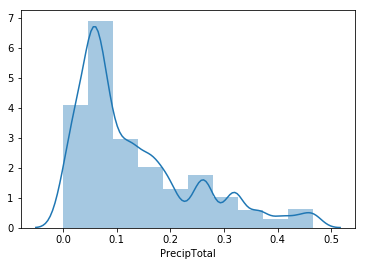

In [81]:
import seaborn as sns

sns.distplot(train.PrecipTotal,bins=10)

In [85]:
spray.Date.value_counts()

2013-08-15    2668
2013-08-29    2302
2013-07-17    2202
2011-09-07    2114
2013-07-25    1607
2013-08-22    1587
2013-08-08    1195
2013-09-05     924
2013-08-16     141
2011-08-29      95
Name: Date, dtype: int64

## Generate artificial prediction data for cost-benefit model analysis

Our model will have trap ID, week of the year (1-52), and a probability of West Nile virus being found in the area around a given trap during a given week of the year.

This section is to generate artificial model output data for cost-benefit model analysis purposes, and will be replaced by the true output data once the final model is run.

In [5]:
# Generate empties

listed = list(range(1,151))
traps = [0]*150
weeks = [0]*52
weeknums = list(range(1,53))

In [6]:
from itertools import cycle

In [8]:
trapcyc = cycle(listed)

for ii in range(len(traps)):
    t_id = str(next(trapcyc))
    traps[ii] = "T"+str(t_id)

In [11]:
trapdict = {key:[np.random.random() for ii in range(1,53)] for key in traps}

In [12]:
trapdict

{'T1': [0.18661250484694158,
  0.19699635160179851,
  0.47522354860849847,
  0.7124006531605956,
  0.1866326413219056,
  0.3094250820865826,
  0.7541977675121949,
  0.8113317494671967,
  0.7838286717053455,
  0.17019866990301968,
  0.5943246367687177,
  0.8224390370572565,
  0.8034140623080133,
  0.48858359631260706,
  0.3481407066559804,
  0.17373489929012342,
  0.20410603120087156,
  0.2036523118135054,
  0.37213618469786847,
  0.5055841163291463,
  0.3522144786197767,
  0.5469311222373622,
  0.8963718719436101,
  0.9433629710634068,
  0.5978117212884156,
  0.6135290492484149,
  0.7610616000285767,
  0.6161650782174197,
  0.9976389062990269,
  0.46962204199489455,
  0.5206500871980239,
  0.9891159790501673,
  0.984960745596239,
  0.13595274801521662,
  0.37420828045025367,
  0.6041694398725709,
  0.22499119274536516,
  0.2461760429983325,
  0.6967438586773694,
  0.8811014729990405,
  0.712747709843317,
  0.2527178406963009,
  0.43640763583649567,
  0.9611658910867221,
  0.36922087811

In [15]:
trap_rolls = [0]*150
for ii in range(len(trap_rolls)):
    trap_rolls[ii] = traps[ii] + "roll"

In [16]:
trap_rolls

['T1roll',
 'T2roll',
 'T3roll',
 'T4roll',
 'T5roll',
 'T6roll',
 'T7roll',
 'T8roll',
 'T9roll',
 'T10roll',
 'T11roll',
 'T12roll',
 'T13roll',
 'T14roll',
 'T15roll',
 'T16roll',
 'T17roll',
 'T18roll',
 'T19roll',
 'T20roll',
 'T21roll',
 'T22roll',
 'T23roll',
 'T24roll',
 'T25roll',
 'T26roll',
 'T27roll',
 'T28roll',
 'T29roll',
 'T30roll',
 'T31roll',
 'T32roll',
 'T33roll',
 'T34roll',
 'T35roll',
 'T36roll',
 'T37roll',
 'T38roll',
 'T39roll',
 'T40roll',
 'T41roll',
 'T42roll',
 'T43roll',
 'T44roll',
 'T45roll',
 'T46roll',
 'T47roll',
 'T48roll',
 'T49roll',
 'T50roll',
 'T51roll',
 'T52roll',
 'T53roll',
 'T54roll',
 'T55roll',
 'T56roll',
 'T57roll',
 'T58roll',
 'T59roll',
 'T60roll',
 'T61roll',
 'T62roll',
 'T63roll',
 'T64roll',
 'T65roll',
 'T66roll',
 'T67roll',
 'T68roll',
 'T69roll',
 'T70roll',
 'T71roll',
 'T72roll',
 'T73roll',
 'T74roll',
 'T75roll',
 'T76roll',
 'T77roll',
 'T78roll',
 'T79roll',
 'T80roll',
 'T81roll',
 'T82roll',
 'T83roll',
 'T84roll',
 

In [17]:
traprollsdict = {key:weeks for key in trap_rolls}

In [18]:
traprollsdict

{'T100roll': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'T101roll': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'T102roll': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'T103roll': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,

In [19]:
traprolls = pd.DataFrame(traprollsdict, index=weeknums)

In [20]:
traprolls.head()

,T100roll,T101roll,T102roll,T103roll,T104roll,T105roll,T106roll,T107roll,T108roll,T109roll,...,T91roll,T92roll,T93roll,T94roll,T95roll,T96roll,T97roll,T98roll,T99roll,T9roll
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
trap_df = pd.DataFrame(trapdict, index=weeknums)

In [14]:
trap_df

,T1,T10,T100,T101,T102,T103,T104,T105,T106,T107,...,T90,T91,T92,T93,T94,T95,T96,T97,T98,T99
1,0.186613,0.445825,0.487435,0.141399,0.917625,0.760458,0.561594,0.471354,0.219665,0.413718,...,0.621314,0.509603,0.807624,0.930181,0.746001,0.204225,0.110567,0.790500,0.647114,0.699596
2,0.196996,0.894746,0.778100,0.502911,0.351473,0.435365,0.867415,0.382308,0.746621,0.245967,...,0.140916,0.159906,0.119946,0.308593,0.208523,0.695464,0.213952,0.061914,0.899276,0.539253
3,0.475224,0.496237,0.574605,0.396275,0.547356,0.454826,0.028206,0.774563,0.142106,0.398601,...,0.415322,0.435086,0.913811,0.410532,0.974012,0.256210,0.907503,0.505080,0.493745,0.363109
4,0.712401,0.168803,0.409661,0.827221,0.660918,0.471058,0.746275,0.338045,0.100649,0.432336,...,0.800802,0.225549,0.230477,0.499223,0.939285,0.091346,0.642605,0.163703,0.103785,0.156280
5,0.186633,0.240919,0.021281,0.393114,0.201714,0.640056,0.892644,0.082013,0.730917,0.253849,...,0.646104,0.758718,0.278081,0.158102,0.893899,0.855252,0.364950,0.897512,0.584505,0.380534
6,0.309425,0.164565,0.836636,0.395074,0.523860,0.183201,0.192935,0.421108,0.973737,0.874625,...,0.032457,0.292246,0.537906,0.501069,0.214209,0.705892,0.658412,0.010146,0.589370,0.199374
7,0.754198,0.510386,0.922188,0.231512,0.740869,0.254826,0.291854,0.005985,0.749390,0.237867,...,0.858006,0.236391,0.577157,0.240851,0.858044,0.882075,0.900669,0.468601,0.046567,0.202411
8,0.811332,0.370064,0.522133,0.148078,0.874556,0.640564,0.666253,0.486313,0.928006,0.083207,...,0.812593,0.658974,0.157445,0.169310,0.038618,0.109786,0.876073,0.220333,0.676345,0.088247
9,0.783829,0.238276,0.859140,0.325638,0.404062,0.831885,0.897808,0.582867,0.219570,0.301642,...,0.246731,0.257607,0.028953,0.012857,0.596719,0.102622,0.701689,0.955399,0.353996,0.454832
10,0.170199,0.370205,0.958631,0.807535,0.544996,0.457620,0.247010,0.727174,0.352000,0.483129,...,0.874818,0.677058,0.598864,0.421268,0.223093,0.449682,0.361248,0.675136,0.893764,0.234364


In [21]:
alltrapinfo = pd.concat([trap_df,traprolls],axis=1)

In [23]:
alltrapinfo.head(2)

,T1,T10,T100,T101,T102,T103,T104,T105,T106,T107,...,T91roll,T92roll,T93roll,T94roll,T95roll,T96roll,T97roll,T98roll,T99roll,T9roll
1,0.186613,0.445825,0.487435,0.141399,0.917625,0.760458,0.561594,0.471354,0.219665,0.413718,...,0,0,0,0,0,0,0,0,0,0
2,0.196996,0.894746,0.778100,0.502911,0.351473,0.435365,0.867415,0.382308,0.746621,0.245967,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# function to use a rolling two-week window to decide whether an area should be sprayed
# if a period

def rolling_sprays(df, window=2, min_period=1):
    
    # use only the columns with trap IDs
    cols = df.columns
    trapsonly = [col for col in cols if col.find('roll') < 0]
    
    df = pd.concat([df,])
    
    
    return df

In [30]:
tcols = alltrapinfo.columns
justtraps = [col for col in tcols if col.find('roll') < 0]
justtraps

['T1',
 'T10',
 'T100',
 'T101',
 'T102',
 'T103',
 'T104',
 'T105',
 'T106',
 'T107',
 'T108',
 'T109',
 'T11',
 'T110',
 'T111',
 'T112',
 'T113',
 'T114',
 'T115',
 'T116',
 'T117',
 'T118',
 'T119',
 'T12',
 'T120',
 'T121',
 'T122',
 'T123',
 'T124',
 'T125',
 'T126',
 'T127',
 'T128',
 'T129',
 'T13',
 'T130',
 'T131',
 'T132',
 'T133',
 'T134',
 'T135',
 'T136',
 'T137',
 'T138',
 'T139',
 'T14',
 'T140',
 'T141',
 'T142',
 'T143',
 'T144',
 'T145',
 'T146',
 'T147',
 'T148',
 'T149',
 'T15',
 'T150',
 'T16',
 'T17',
 'T18',
 'T19',
 'T2',
 'T20',
 'T21',
 'T22',
 'T23',
 'T24',
 'T25',
 'T26',
 'T27',
 'T28',
 'T29',
 'T3',
 'T30',
 'T31',
 'T32',
 'T33',
 'T34',
 'T35',
 'T36',
 'T37',
 'T38',
 'T39',
 'T4',
 'T40',
 'T41',
 'T42',
 'T43',
 'T44',
 'T45',
 'T46',
 'T47',
 'T48',
 'T49',
 'T5',
 'T50',
 'T51',
 'T52',
 'T53',
 'T54',
 'T55',
 'T56',
 'T57',
 'T58',
 'T59',
 'T6',
 'T60',
 'T61',
 'T62',
 'T63',
 'T64',
 'T65',
 'T66',
 'T67',
 'T68',
 'T69',
 'T7',
 'T70',
 'T7

In [31]:
pseudodata

,trapid,week,wnv_prob
0,T1,1,0.048428
1,T1,2,0.776857
2,T1,3,0.049503
3,T1,4,0.240677
4,T1,5,0.831957
5,T1,6,0.227399
6,T1,7,0.609636
7,T1,8,0.814128
8,T1,9,0.803408
9,T1,10,0.453117


In [34]:
thresholds = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

In [39]:
pct0 = (pseudodata.wnv_prob > thresholds[0])*1
pct10 = 1*(pseudodata.wnv_prob > thresholds[1])
pct20 = 1*(pseudodata.wnv_prob > thresholds[2])
pct30 = 1*(pseudodata.wnv_prob > thresholds[3])
pct40 = 1*(pseudodata.wnv_prob > thresholds[4])
pct50 = 1*(pseudodata.wnv_prob > thresholds[5])
pct60 = 1*(pseudodata.wnv_prob > thresholds[6])
pct70 = 1*(pseudodata.wnv_prob > thresholds[7])
pct80 = 1*(pseudodata.wnv_prob > thresholds[8])
pct90 = 1*(pseudodata.wnv_prob > thresholds[9])
pct100 = 1*(pseudodata.wnv_prob == thresholds[10])

In [41]:
all_pcts = pd.DataFrame({'pct0':pct0, 'pct10':pct10,'pct20':pct20,'pct30':pct30,'pct40':pct40,'pct50':pct50,'pct60':pct60,'pct70':pct70,'pct80':pct80,'pct90':pct90,'pct100':pct100})

In [43]:
all_pseudodata = pd.concat([pseudodata,all_pcts],axis=1)

In [44]:
all_pseudodata

,trapid,week,wnv_prob,pct0,pct10,pct100,pct20,pct30,pct40,pct50,pct60,pct70,pct80,pct90
0,T1,1,0.048428,1,0,0,0,0,0,0,0,0,0,0
1,T1,2,0.776857,1,1,0,1,1,1,1,1,1,0,0
2,T1,3,0.049503,1,0,0,0,0,0,0,0,0,0,0
3,T1,4,0.240677,1,1,0,1,0,0,0,0,0,0,0
4,T1,5,0.831957,1,1,0,1,1,1,1,1,1,1,0
5,T1,6,0.227399,1,1,0,1,0,0,0,0,0,0,0
6,T1,7,0.609636,1,1,0,1,1,1,1,1,0,0,0
7,T1,8,0.814128,1,1,0,1,1,1,1,1,1,1,0
8,T1,9,0.803408,1,1,0,1,1,1,1,1,1,1,0
9,T1,10,0.453117,1,1,0,1,1,1,0,0,0,0,0


In [45]:
all_pseudodata.to_csv('pseudodataoutput.csv')

In [48]:
tested = pd.read_csv('pseudodataoutput.csv')
tested.drop(['Unnamed: 0'],axis=1,inplace=True)
tested.head()


,trapid,week,wnv_prob,pct0,pct10,pct100,pct20,pct30,pct40,pct50,pct60,pct70,pct80,pct90
0,T1,1,0.048428,1,0,0,0,0,0,0,0,0,0,0
1,T1,2,0.776857,1,1,0,1,1,1,1,1,1,0,0
2,T1,3,0.049503,1,0,0,0,0,0,0,0,0,0,0
3,T1,4,0.240677,1,1,0,1,0,0,0,0,0,0,0
4,T1,5,0.831957,1,1,0,1,1,1,1,1,1,1,0
